# This notebook shows the process of the automatic labeling

In [1]:
import os
import sys
import pandas as pd
import matplotlib.pyplot as plt
import ast
import plotly.offline as py
import json
import plotly.express as px
import webbrowser
from dash import Dash, dcc, html, Input, Output
import random

# Import library with current code functions
sys.path.append(os.path.join("..", "lib"))
import manual_labeler_functions as man_lab_fun, automatic_labeler_functions as aut_lab_fun, general_functions as gf, files_paths as fp

import time

In [2]:
def PLOT_MEASURE_EXPLORER(df):

    port = random.randint(5000, 5500)
    external_stylesheets = ['https://codepen.io/chriddyp/pen/bWLwgP.css']
    app = Dash(__name__, external_stylesheets=external_stylesheets)

    def open_browser():
    	webbrowser.open_new("http://localhost:{}".format(port))
          
    app.layout = html.Div([
        html.H4('Measure Explorer'),
        html.H6('Reference Signal'),
        html.I('Setting the frame interval range'),
        html.Br(),
        dcc.Input(id='input-init', type='number', min=df.index.min(), max=df.index.max(), value=df.index.min()),
        dcc.Input(id='input-end', type='number', value=df.index.max()),
        dcc.Graph(id="graph"),
        dcc.Checklist(
            id="checklist",
            options=df.columns,
            value=["m1", "m3"],
            inline=True
        ),
        dcc.Store(
        id='data-output',
        data=[{
            'measures': ["m1", "m3"],
            'init_label': df.index.min(),
            'end_label': df.index.max()
        }]
        ),
        html.Br(),
        html.Details([
        html.Summary('Input Parameters'),
        dcc.Markdown(id='clientside-figure-json')
        ])
    ])
    
    @app.callback(
        Output("graph", "figure"), 
        Input("checklist", "value"),
        Input("input-init", "value"),
        Input("input-end", "value"))
    def update_line_chart(measures, frame_init, frame_end):
        mask = df.columns.isin(measures)
        filtered_df = df.loc[frame_init:frame_end, mask]
        fig = px.line(filtered_df, width=900, height=400, labels={
                     "frame_seq": "<b>Frame number</b>",
                     "value": "<b>Amplitude (pixels)</b>",
                     "variable": "<b>Measures</b>"
                 },)
        data = measures
        fig.update_layout(
            plot_bgcolor='white',
            font_size=12,
        )
        fig.update_xaxes(
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            gridcolor='lightgrey',
        )
        fig.update_yaxes(
            mirror=True,
            ticks='outside',
            showline=True,
            linecolor='black',
            gridcolor='lightgrey',
        )
        return fig

    @app.callback(
        Output('data-output', 'data'),
        Input("checklist", "value"),
        Input("input-init", "value"),
        Input("input-end", "value"))
    def update_store_data(measures, frame_init, frame_end):
        mask = df.columns.isin(measures)
        filtered_df = df.loc[:,mask]
        return [{
            'measures': filtered_df.columns,
            'init_label': frame_init,
            'end_label': frame_end
        }]
    
    
    @app.callback(
        Output('clientside-figure-json', 'children'),
        Input('data-output', 'data')
    )
    def generated_data_json(data):
        return '```\n'+json.dumps(data, indent=2)+'\n```'
   
    if __name__ == '__main__':
        app.run_server(debug=True, port=port)

In [3]:
def show_seed_frames(seed_num, n_frames_per_row):
    if seed_num != 0:
        if seed_num < 10:
            vd_info_folder = gf.find_files_in_all_subdirectories([fp.DATASET_SEED], f'*VD_R_000000000*{seed_num}*')
        else:
            vd_info_folder = gf.find_files_in_all_subdirectories([fp.DATASET_SEED], f'*VD_R_*{seed_num}*')
            
        vd_labeled_file = gf.find_files_in_all_subdirectories([vd_info_folder[0]], fp.VD_LABELED_L0)[0]
        vd_info_file = gf.find_files_in_all_subdirectories([vd_info_folder[0]], fp.VD_INFO)[0]

        vd_info_df = pd.read_csv(vd_info_file)
        video_name = vd_info_df['link_video']

        vd_labeled_df = pd.read_csv(vd_labeled_file)
        vd_labeled_df_measure = [group for group in vd_labeled_df.groupby('label_measures')]
        
        first_frame = list(vd_labeled_df_measure[0][1]['frame_seq'])[0]
        last_frame = list(vd_labeled_df_measure[0][1]['frame_seq'])[-1]

        video_seed_path = gf.find_files_in_all_subdirectories([fp.VIDEO_SOURCE_SEED], f'*{video_name[0]}.mp4')[0]

        print("Video seed path", video_seed_path)
        print("Video labeled path:", vd_labeled_file)
        print("Video name:", video_name[0])
        print("Video ID", seed_num)
        print("Frame start:", first_frame)
        print("Frame start:", last_frame)

        video_frames = man_lab_fun.LOAD_VIDEO_FRAMES(video_seed_path)
        man_lab_fun.DISPLAY_FRAMES(video_frames, first_frame, last_frame, n_frames_per_row)

In [4]:
def show_marked_frames(SAMPLE_ID, file_path):

    current_labeled_file_df = pd.read_csv(file_path)
    all_label_measures = [label_measure for label_measure in current_labeled_file_df.groupby('sample_id')]

    VIDEO_EXT = '.mp4'

    VIDEO_ID = list(all_label_measures[SAMPLE_ID][1]['video_id'])[0]

    # Get path from selected video id
    video_name = str(INDEX_DT.loc[VIDEO_ID,'link_video']) + VIDEO_EXT

    path_video_file = os.path.join(fp.VIDEO_SOURCE_LOCAL, video_name)

    start_frame_crop = list(all_label_measures[SAMPLE_ID-1][1]['frame_seq'])[0]
    end_frame_crop = list(all_label_measures[SAMPLE_ID-1][1]['frame_seq'])[-1]
    n_frames_per_row = 5

    video_frames = man_lab_fun.LOAD_VIDEO_FRAMES(path_video_file, start_frame_crop, end_frame_crop, False)

    print("Total number samples:", len(all_label_measures))
    print("Video name:", video_name)
    print("Video ID", VIDEO_ID)
    print("Measure:", all_label_measures[SAMPLE_ID-1][1]['label_measures'].iloc[0])
    print("Frame start:", start_frame_crop)
    print("Frame start:", end_frame_crop)

    man_lab_fun.DISPLAY_FRAMES(video_frames, start_frame_crop, end_frame_crop, n_frames_per_row)

    return VIDEO_ID, start_frame_crop, end_frame_crop

In [5]:
def show_frames_series(video_id, video_origin, frame_start=0, frame_end=99999999):
    if video_id != 0:
        if video_id < 10:
            vd_info_folder = gf.find_files_in_all_subdirectories([video_origin], f'*VD_*_000000000*{video_id}*')
        elif video_id >= 10:
            vd_info_folder = gf.find_files_in_all_subdirectories([video_origin], f'*VD_*_*{video_id}*')

        vd_labeled_file = gf.find_files_in_all_subdirectories([vd_info_folder[0]], fp.VD_LABELED_L0)[0]
        vd_info_file = gf.find_files_in_all_subdirectories([vd_info_folder[0]], fp.VD_INFO)[0]
        
        vd_labeled_df = pd.read_csv(vd_labeled_file)
        features = vd_labeled_df.iloc[frame_start:frame_end, 4:26]

        PLOT_MEASURE_EXPLORER(features)
        vd_info_df = pd.read_csv(vd_info_file)
        print("vd_info_df", vd_info_df)

## Getting the list of measure files to be labeled and the list of seed available

In [6]:
FILE_LIST_VD_LABELED = gf.find_files_in_all_subdirectories([fp.DATASET_YT, fp.DATASET_LOCAL], fp.VD_LABELED_L0)
FILE_LIST_SEED = gf.find_files_in_all_subdirectories([fp.DATASET_SEED], fp.VD_LABELED_L0)

In [7]:
FILE_LIST_VD_LABELED

['..\\Dataset\\DD-Local\\VD_D_0000000001\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000002\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000003\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000004\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000005\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000006\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000007\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000008\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000009\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000010\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000011\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000012\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000013\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000014\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000015\\VD_LABELED_L0.CSV',
 '..\\Dataset\\DD-Local\\VD_D_0000000016\\VD_LABELED_L0.CSV',
 '..\\Da

In [8]:
INDEX_DT = man_lab_fun.CREATE_LABELED_INDEX(FILE_LIST_VD_LABELED[:20])

In [9]:
INDEX_DT

,link_video,duration_vid,total_frames,label_file_exist,path
video_id,,,,,
1,295xopXuU5E,89.30,2676,1,..\Dataset\DD-Local\VD_D_0000000001
2,2q_eNp4mDGU,83.68,2507,1,..\Dataset\DD-Local\VD_D_0000000002
3,4W09LPCCJ4U,79.90,2394,1,..\Dataset\DD-Local\VD_D_0000000003
4,5KY8V6HBAro,213.28,6398,1,..\Dataset\DD-Local\VD_D_0000000004
5,61gzN0c9K3g,142.78,4279,1,..\Dataset\DD-Local\VD_D_0000000005
6,6koC82XF9bc,174.08,5217,1,..\Dataset\DD-Local\VD_D_0000000006
7,8hDfY5JR4Ic,146.15,4380,1,..\Dataset\DD-Local\VD_D_0000000007
8,AjHji_Ff4Mc,140.92,4223,1,..\Dataset\DD-Local\VD_D_0000000008
9,H9HzZV6pW7g,273.95,8218,1,..\Dataset\DD-Local\VD_D_0000000009


# Check prepared data

Maximum number of frames: 1000. Edit it with caution, it uses a lot of memory!!!
Total number samples: 3704
Video name: 295xopXuU5E.mp4
Video ID 1
Measure: {'happy': (['m1', 'm3', 'm12', 'e1', 'e2'], 5.643065729555414, 15), 'neutral': (['m1', 'm3', 'm12', 'e1', 'e2'], 3.9958100252746394, 127)}
Frame start: 1048
Frame start: 1098


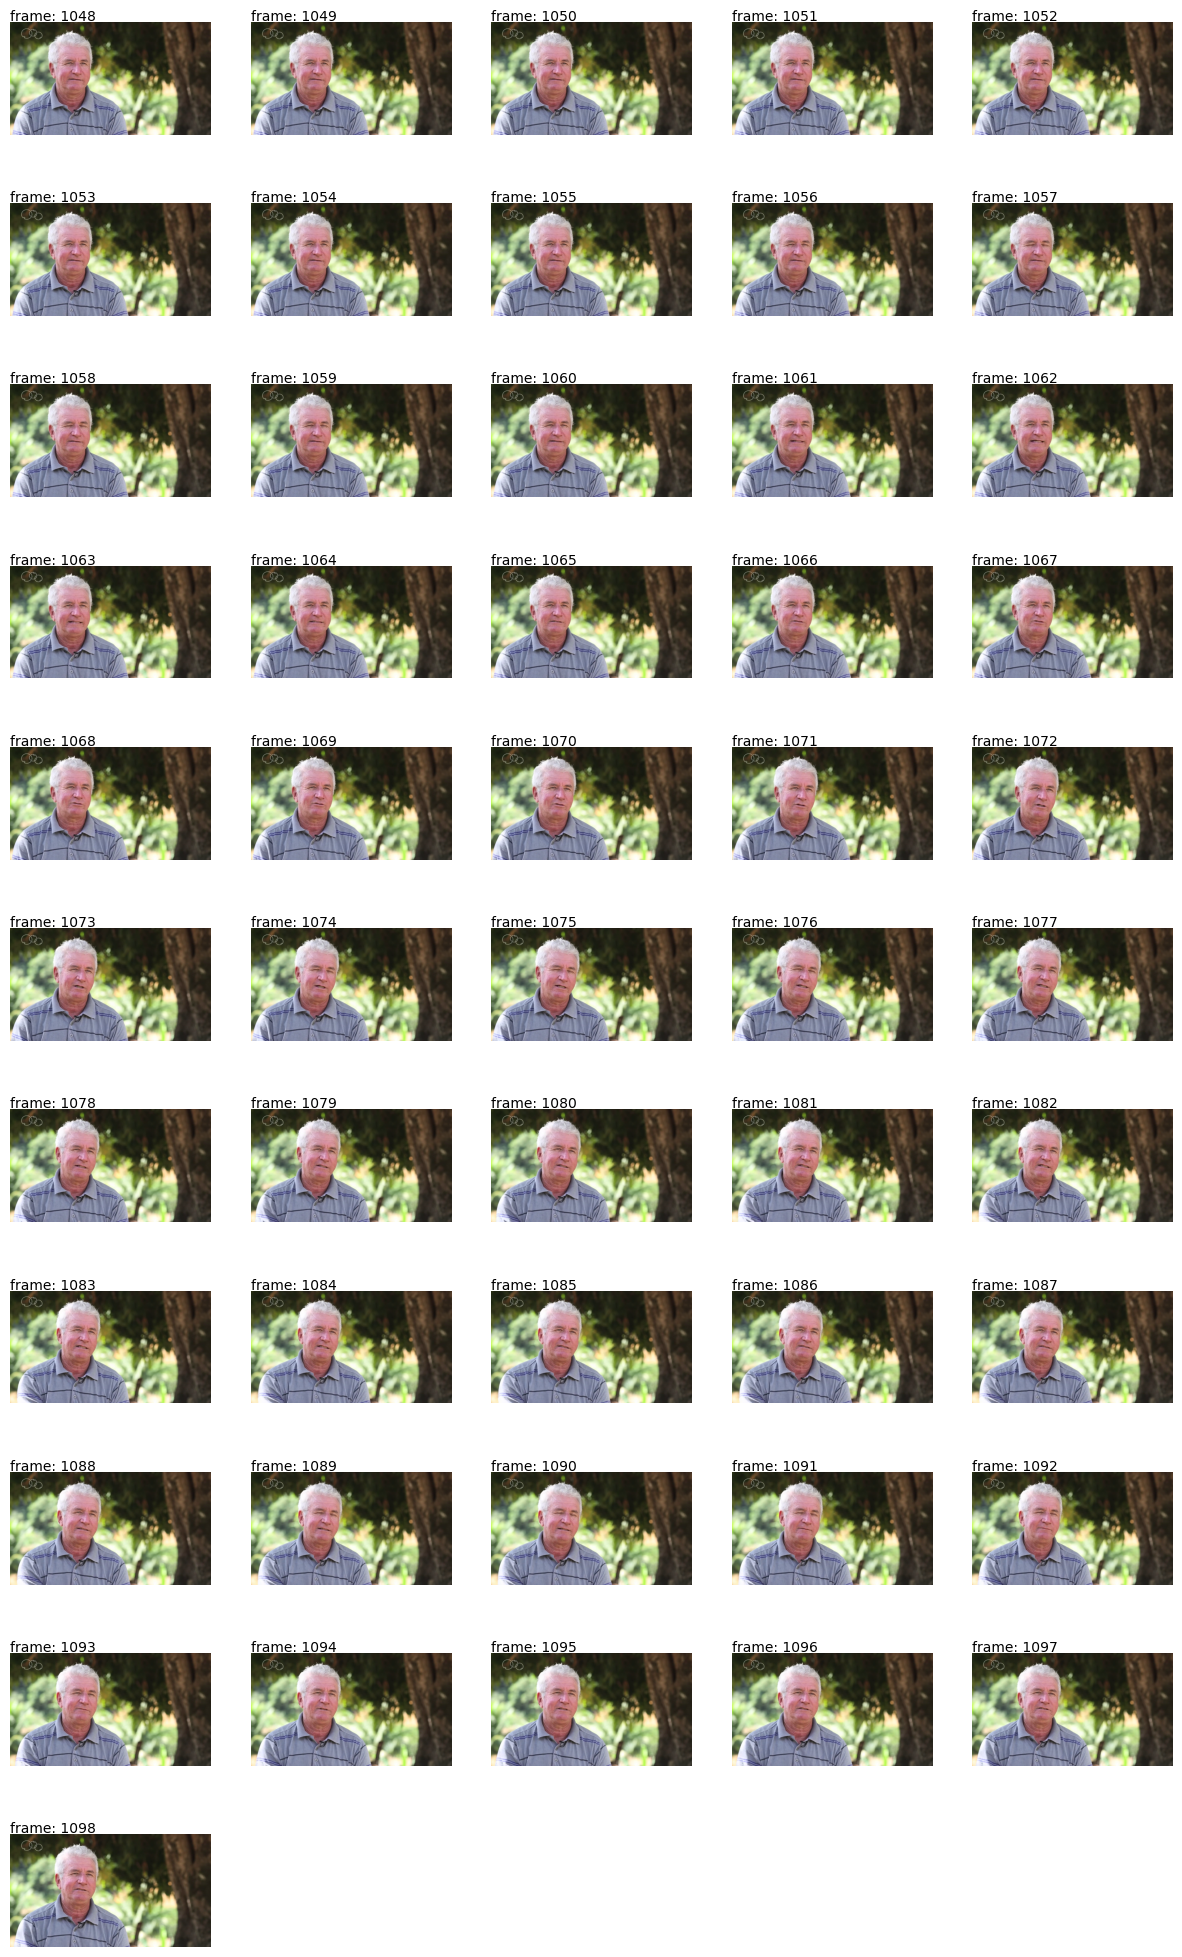

In [10]:
file_path = './DATASET_SEQUENCES_2.CSV'

SAMPLE_ID = 8
video_id, start_frame_crop, end_frame_crop = show_marked_frames(SAMPLE_ID, file_path)

In [11]:
show_frames_series(video_id, fp.DATASET_LOCAL, start_frame_crop, end_frame_crop)

vd_info_df    Unnamed: 0  video_id origin_vid process_status   link_video  height_vid  \
0           0         1          D              L  295xopXuU5E         720   

   width_vid  duration_vid   fps_vid  total_frames  time_step_fr  
0       1280          89.3  29.97003          2676      0.033367  


In [12]:
show_frames_series(video_id, fp.DATASET_LOCAL, start_frame_crop, end_frame_crop)

vd_info_df    Unnamed: 0  video_id origin_vid process_status   link_video  height_vid  \
0           0         1          D              L  295xopXuU5E         720   

   width_vid  duration_vid   fps_vid  total_frames  time_step_fr  
0       1280          89.3  29.97003          2676      0.033367  


In [13]:
current_labeled_file_df = pd.read_csv(file_path)
all_label_measures = [label_measure for label_measure in current_labeled_file_df.groupby('sample_id')]
n_frames_per_row = 5

# Video seed
try:
    data_dict = ast.literal_eval(all_label_measures[SAMPLE_ID-1][1]['label_measures'].iloc[0])
except (ValueError, SyntaxError) as e:
    print("Erro ao converter a string para dicionário:", e)
    data_dict = {}

# Extrair os números desejados
happy_num = data_dict.get('happy', ([], 0.0, 0))[2]
neutral_num = data_dict.get('neutral', ([], 0.0, 0))[2]

Video seed path ..\Video-Source\in_REF-Gold\4W09LPCCJ4U_happy_3.mp4
Video labeled path: ..\Dataset\REF-Gold-Label\VD_R_0000000015\VD_LABELED_L0.CSV
Video name: 4W09LPCCJ4U_happy_3
Video ID 15
Frame start: 0
Frame start: 29
Maximum number of frames: 1000. Edit it with caution, it uses a lot of memory!!!


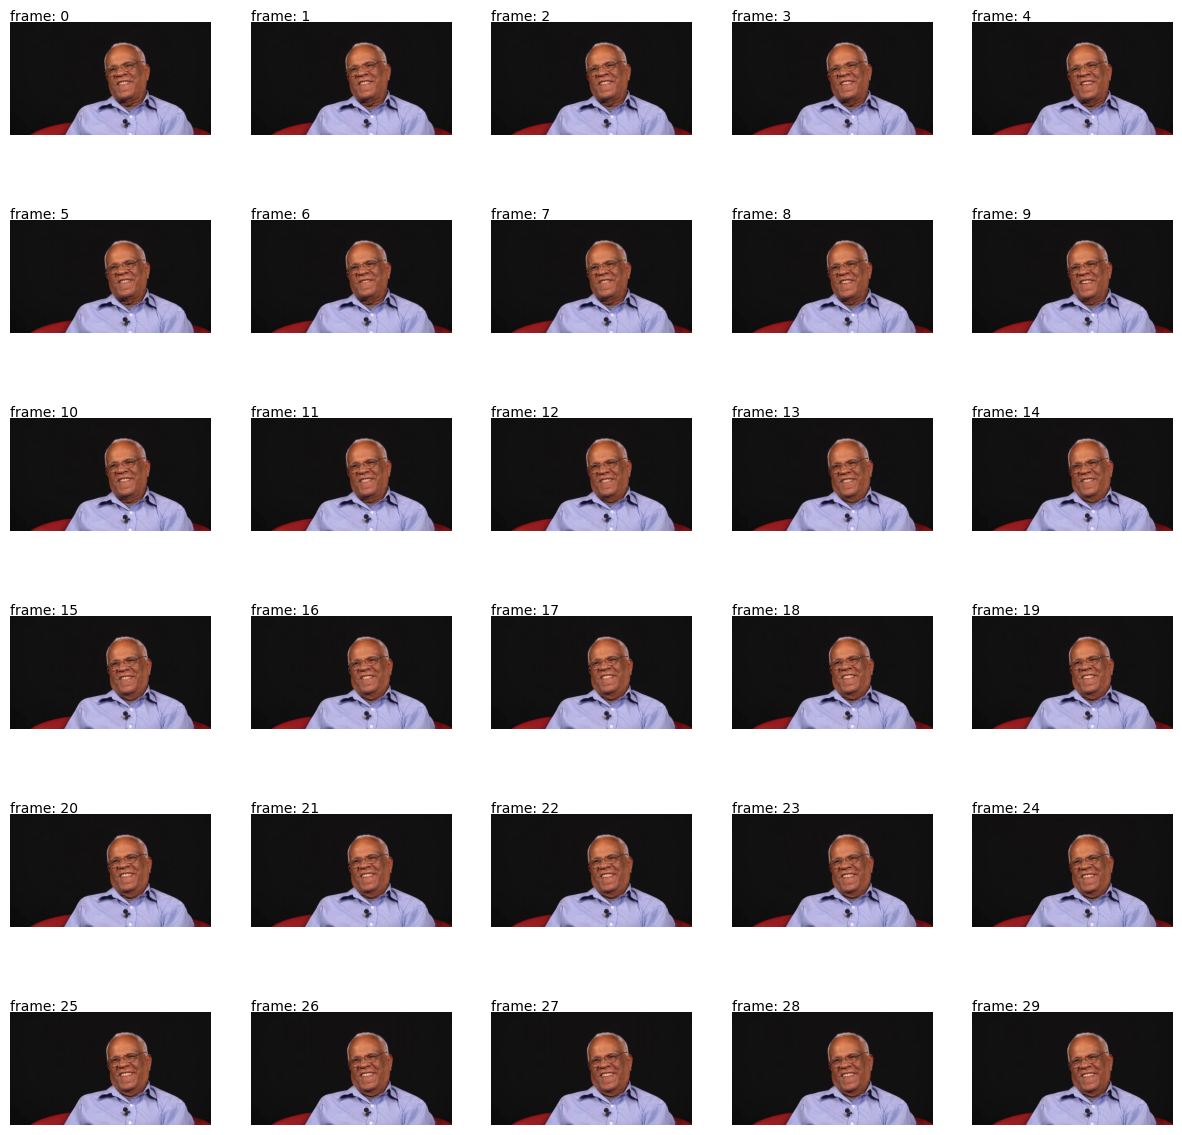

In [14]:
show_seed_frames(happy_num, n_frames_per_row)

In [15]:
show_frames_series(happy_num, fp.DATASET_SEED)

vd_info_df    Unnamed: 0  video_id origin_vid process_status           link_video  \
0           0        15          D              L  4W09LPCCJ4U_happy_3   

   height_vid  width_vid  duration_vid   fps_vid  total_frames  time_step_fr  
0         720       1280          1.02  29.97003            30      0.033367  


Video seed path ..\Video-Source\in_REF-Gold\p9cvrKEFUhc_neutral_2.mp4
Video labeled path: ..\Dataset\REF-Gold-Label\VD_R_0000000127\VD_LABELED_L0.CSV
Video name: p9cvrKEFUhc_neutral_2
Video ID 127
Frame start: 0
Frame start: 29
Maximum number of frames: 1000. Edit it with caution, it uses a lot of memory!!!


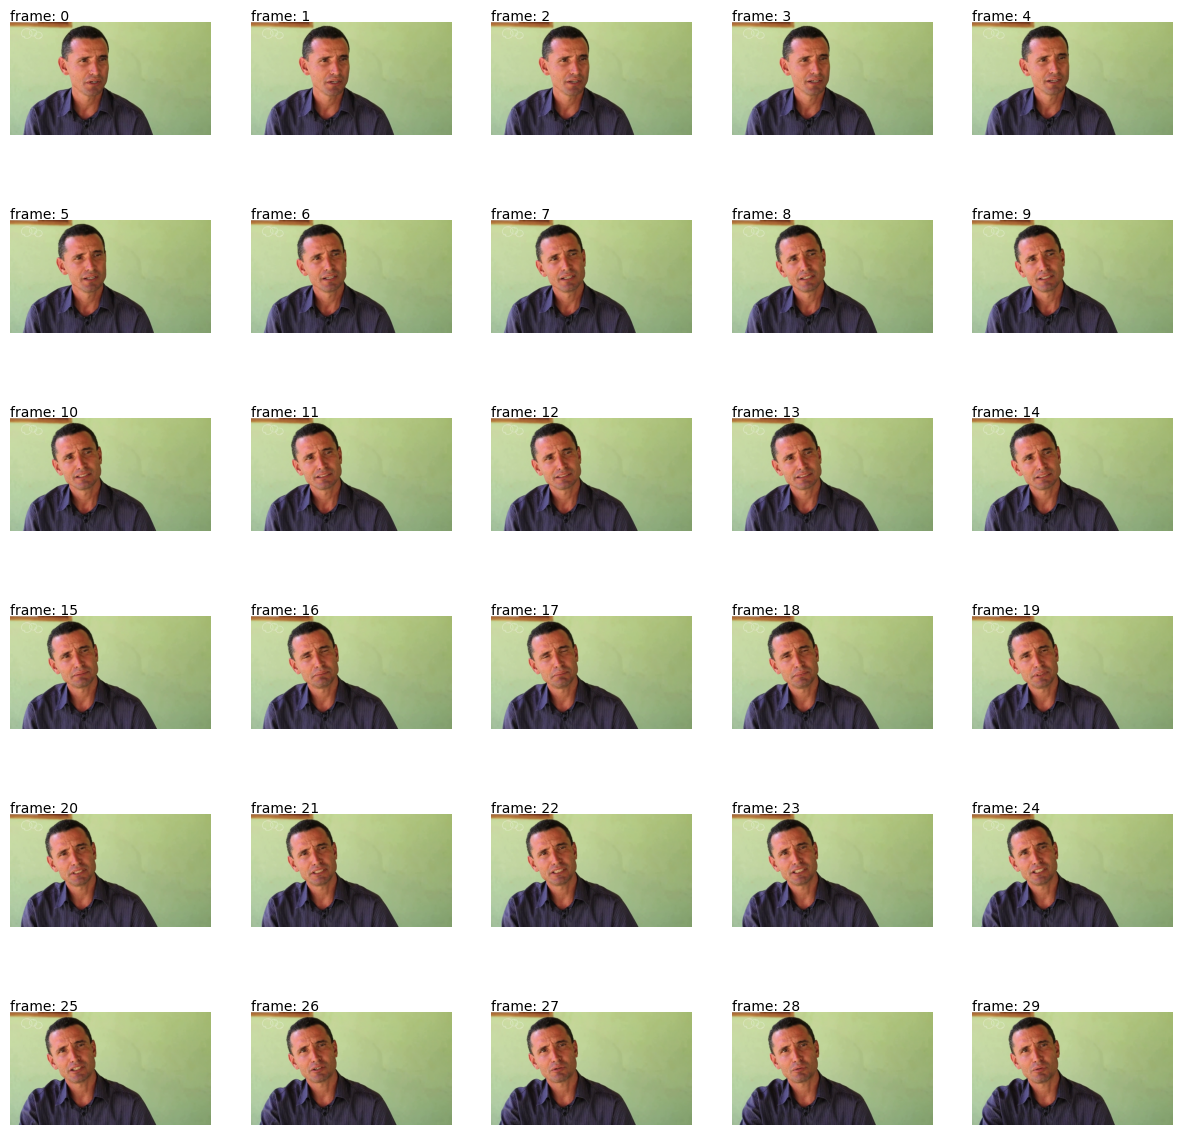

In [16]:
show_seed_frames(neutral_num, n_frames_per_row)

In [17]:
show_frames_series(video_id, fp.DATASET_LOCAL, start_frame_crop, end_frame_crop)

vd_info_df    Unnamed: 0  video_id origin_vid process_status   link_video  height_vid  \
0           0         1          D              L  295xopXuU5E         720   

   width_vid  duration_vid   fps_vid  total_frames  time_step_fr  
0       1280          89.3  29.97003          2676      0.033367  


In [18]:
show_frames_series(neutral_num, fp.DATASET_SEED)

vd_info_df    Unnamed: 0  video_id origin_vid process_status             link_video  \
0           0       127          D              L  p9cvrKEFUhc_neutral_2   

   height_vid  width_vid  duration_vid   fps_vid  total_frames  time_step_fr  
0         720       1280          1.02  29.97003            30      0.033367  
